# Regression

*Approximate an unknown function $f$ that maps from $\mathbb{R}^D$ to $\mathbb{R}^F$.*

**Model:**

* We assume that there is some **latent function** $f: \mathbb{R}^D \rightarrow \mathbb{R}^F$.
* We observe **samples** $(\boldsymbol{x}_n, \boldsymbol{y}_n)$ with $f(\boldsymbol{x}_n) + \boldsymbol{\epsilon}_n = \boldsymbol{y}_n$
* with i.i.d. noise, for example $\boldsymbol{\epsilon}_n \sim \mathcal{N}(0, \sigma^2 \boldsymbol{I}_F)$.

## Overview

**Algorithms**

* Linear Regression
* Polynomial (Ridge) Regression
* Kernel (Ridge) Regression
* Gaussian Process Regression
* Support Vector Regression
* Neural Nets

**Tips**

* Bias vs. Variance
* Model Selection

## Dataset

All samples $\{(\boldsymbol{x}_1, \boldsymbol{y}_1), \ldots, (\boldsymbol{x}_N, \boldsymbol{y}_N)\}$ are called **dataset**.

Here is an example.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.utils import check_random_state


def generate_data(n_samples, sigma, random_state=None):
    random_state = check_random_state(random_state)
    x = np.linspace(0, 1, n_samples)
    X = x[:, np.newaxis]
    y_true = np.cos(2 * np.pi * x)
    y = y_true + sigma * random_state.randn(n_samples)
    return x, X, y_true, y

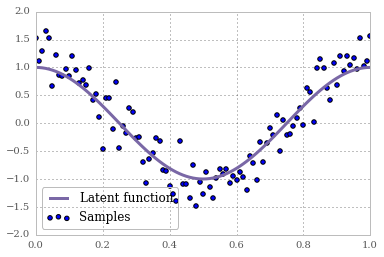

In [3]:
x, X, y_true, y = generate_data(101, 0.3, 0)
plt.plot(x, y_true, label="Latent function")
plt.scatter(x, y, label="Samples")
plt.xlim((0, 1))
plt.legend()

We will only consider the case $F = 1$.

In this case, we can organize the whole dataset in a **design matrix** $\boldsymbol{X} \in \mathbb{R}^{N \times D}$ which contains the input $\boldsymbol{x}_n$ of one sample in each row and a vector $\boldsymbol{y} \in \mathbb{R}^N$ that contains the output $y_n$ of one sample in each entry.

Design matrix

$$\boldsymbol{X}
= \begin{pmatrix}
    \boldsymbol{x}_1^T\\
    \boldsymbol{x}_2^T\\
    \vdots\\
    \boldsymbol{x}_N^T\
  \end{pmatrix}
= \overbrace{
  \begin{pmatrix}
    x_{1,1}&x_{1,2}&\ldots&x_{1,D}\\
    x_{2,1}&x_{2,2}&\ldots&x_{2,D}\\
    \vdots&\vdots&\ddots&\vdots\\
    x_{N,1}&x_{N,2}&\ldots&x_{N,D}
  \end{pmatrix}
  }^\textrm{Features}$$

## Linear Regression

**Model:** We assume that there is some latent function $f: \mathbb{R}^D \rightarrow \mathbb{R}$. We observe samples $(\boldsymbol{x}_n, y_n)$ with $$f(\boldsymbol{x}_n) + \epsilon_n = y_n, \quad \epsilon_n \sim \mathcal{N}(0, \sigma^2).$$

We assume that $f$ is a linear function of the form
$$f(\boldsymbol{x}_n) = \boldsymbol{w}^T \boldsymbol{x}$$
($\boldsymbol{x}$ will be extended by 1 so that $\boldsymbol{w}$ incorporates a bias).

For the whole dataset:
$$\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + \boldsymbol{\epsilon}$$

We will learn by minimizing the **sum of squared errors** (SSE)
$$\arg \min_\boldsymbol{w} \frac{1}{2} || \boldsymbol{y} - \boldsymbol{X} \boldsymbol{w} ||^2_2.$$

We can find a solution for the vector $\boldsymbol{w}$ by setting the derivative of the objective function to 0 and solving for $\boldsymbol{w}$.

\begin{eqnarray*}
&& 0 = \boldsymbol{X}^T \left( \boldsymbol{y} - \boldsymbol{X} \boldsymbol{w} \right) \boldsymbol{X} = \boldsymbol{X}^T \boldsymbol{y} - \boldsymbol{X}^T \boldsymbol{X} \boldsymbol{w}\\
&\Leftrightarrow& \boldsymbol{X}^T \boldsymbol{X} \boldsymbol{w} = \boldsymbol{X}^T \boldsymbol{y}\\
&\Leftrightarrow& \boldsymbol{w} = \left( \boldsymbol{X}^T \boldsymbol{X} \right)^{-1} \boldsymbol{X}^T \boldsymbol{y}
\end{eqnarray*}

(Now we actually have to prove that the second derivative is greater than 0.)

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin


class LinearRegression(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        n_samples = X.shape[0]
        X_bias = np.hstack((np.ones((n_samples, 1)), X))
        self.w = np.linalg.inv(X_bias.T.dot(X_bias)).dot(X_bias.T).dot(y)
        return self

    def predict(self, X):
        n_samples = X.shape[0]
        X_bias = np.hstack((np.ones((n_samples, 1)), X))
        return X_bias.dot(self.w)

In [5]:
def plot_model(model):
    x, X, y_true, y = generate_data(101, 0.3, 0)
    plt.plot(x, y_true, label="Latent function")
    plt.scatter(x, y, label="Samples")
    plt.plot(x, model.predict(X), label="Prediction")
    plt.xlim((0, 1))
    plt.legend()

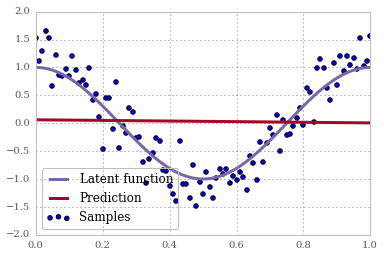

In [6]:
x, X, y_true, y = generate_data(101, 0.3, 0)
plot_model(LinearRegression().fit(X, y))

**Problems:**

* linear model
* complexity of inverse depends on features: $O(D^3)$
* alternative: we can use the iterative algorithm gradient descent; requires multiple iterations over the whole dataset

## Nonlinear Regression

We can extend the linear model to approximate nonlinear functions by

* using fixed nonlinear features (polynomial regression, radial basis function networks, ...)
* learning nonlinear features (neural nets)
* using nonlinear similarities (kernel methods)
* mixing multiple linear models (local regression)

## Ingredients for Machine Learning

Machine learning algorithms often consist of
* a parameterized function (e.g. $\boldsymbol{X} \boldsymbol{w}$, $\boldsymbol{w}$ are the parameters)
* an objective function (e.g. $\frac{1}{2} || \boldsymbol{y} - \hat{\boldsymbol{y}} ||^2_2$)
* an optimization procedure

## Polynomial Regression

We can approximate nonlinear functions with linear regression by generating nonlinear features $\phi(\boldsymbol{x})$.

For example:
$$\left( x_1, x_2 \right) \rightarrow \left( x_1^3, x_2^3, x_1^2x_2, x_1 x_2^2, x_1^2, x_2^2, x_1 x_2, x_1, x_2, 1 \right)$$

In [7]:
from sklearn.preprocessing import PolynomialFeatures


class PolynomialRegression(BaseEstimator, RegressorMixin):
    def __init__(self, degree):
        self.degree = degree

    def fit(self, X, y):
        self.poly = PolynomialFeatures(degree=self.degree).fit(X)
        X_poly = self.poly.transform(X)
        self.w = np.linalg.pinv(X_poly.T.dot(X_poly)).dot(X_poly.T).dot(y)
        return self

    def predict(self, X):
        X_poly = self.poly.transform(X)
        return X_poly.dot(self.w)

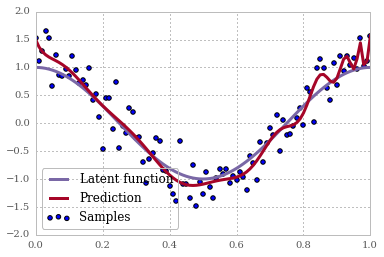

In [8]:
plot_model(PolynomialRegression(100).fit(X, y))

**Problems:**

* overfitting
* features have to be selected
* makes the problem of cubic complexity worse (more features)

## Bias vs. Variance

In [9]:
def plot_bias_variance_error():
    plt.setp(plt.gca(), xticks=(), yticks=(), xlabel="Model Complexity", ylabel="Error")
    resolution = 100
    complexity = np.linspace(0, 4, resolution)
    noise_error = np.ones(resolution) * 0.1
    bias_error = np.exp(-complexity)
    variance_error = np.exp(complexity - np.max(complexity))
    plt.plot(complexity, bias_error, label="Bias")
    plt.plot(complexity, variance_error, label="Variance")
    plt.plot(complexity, noise_error, label="Noise")
    plt.plot(complexity, bias_error + variance_error + noise_error, label="Total")
    plt.legend(loc="best")

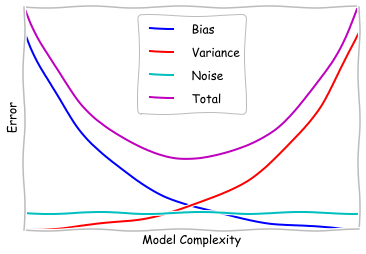

In [10]:
with plt.xkcd():
    plot_bias_variance_error()

In [11]:
def plot_bias_variance():
    plt.figure(figsize=(12, 12))
    def plot_target():
        t = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(t), np.sin(t))
        plt.plot(0.67 * np.cos(t), 0.67 * np.sin(t))
        plt.plot(0.33 * np.cos(t), 0.33 * np.sin(t))
        plt.scatter(0, 0, color="black", s=100)
    plt.setp(plt.subplot(2, 2, 1, aspect="equal"), xticks=(), yticks=())
    plot_target()
    plt.title("Low Variance")
    plt.ylabel("Low Bias")
    plt.scatter((np.random.rand(10)-0.5)*0.2, (np.random.rand(10)-0.5)*0.2, s=50)
    plt.setp(plt.subplot(2, 2, 2, aspect="equal"), xticks=(), yticks=())
    plot_target()
    plt.title("High Variance")
    plt.scatter((np.random.rand(10)-0.5)*0.8, (np.random.rand(10)-0.5)*0.8, s=50)
    plt.setp(plt.subplot(2, 2, 3, aspect="equal"), xticks=(), yticks=())
    plot_target()
    plt.ylabel("High Bias")
    plt.scatter((np.random.rand(10)-0.5)*0.2+0.5, (np.random.rand(10)-0.5)*0.2+0.5, s=50)
    plt.setp(plt.subplot(2, 2, 4, aspect="equal"), xticks=(), yticks=())
    plot_target()
    plt.scatter((np.random.rand(10)-0.5)*0.8+0.5, (np.random.rand(10)-0.5)*0.8+0.5, s=50)

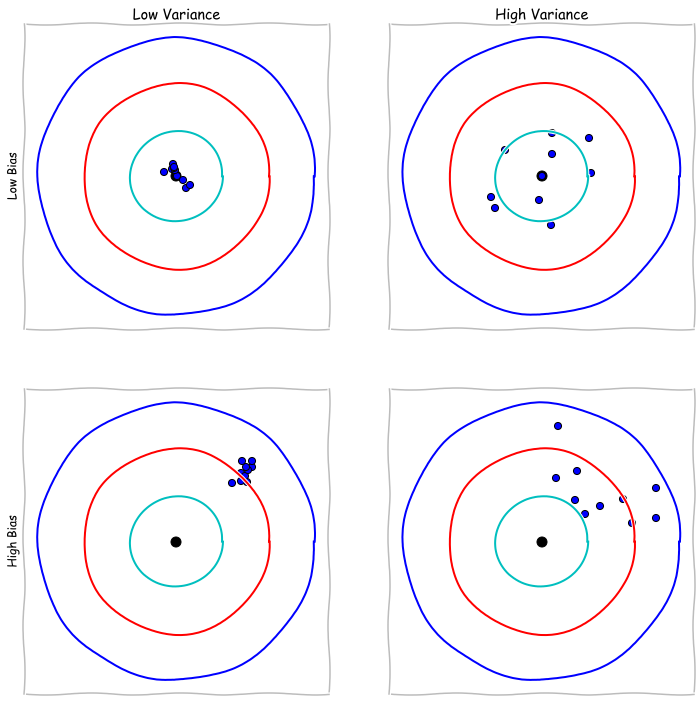

In [12]:
with plt.xkcd():
    plot_bias_variance()

## Ridge Regression

To reduce overfitting, we minimize

$$\arg \min_\boldsymbol{w} \frac{1}{2} || \boldsymbol{y} - \boldsymbol{X} \boldsymbol{w} ||^2_2 + \frac{\gamma}{2} \boldsymbol{w}^T \boldsymbol{w},$$

which means that we set a prior for $\boldsymbol{w}$.

\begin{eqnarray*}
&& 0 = -\boldsymbol{X}^T \left( \boldsymbol{y} - \boldsymbol{X} \boldsymbol{w} \right) + \gamma \boldsymbol{w}\\
&\Leftrightarrow& \boldsymbol{X}^T \boldsymbol{X} \boldsymbol{w} + \gamma \boldsymbol{w} = \boldsymbol{X}^T \boldsymbol{y}\\
&\Leftrightarrow& \boldsymbol{w} = \left( \boldsymbol{X}^T \boldsymbol{X} + \gamma \boldsymbol{I} \right)^{-1} \boldsymbol{X}^T \boldsymbol{y}
\end{eqnarray*}

In [13]:
class PolynomialRidgeRegression(BaseEstimator, RegressorMixin):
    def __init__(self, degree, gamma):
        self.degree = degree
        self.gamma = gamma

    def fit(self, X, y):
        self.poly = PolynomialFeatures(degree=self.degree).fit(X)
        X_poly = self.poly.transform(X)
        self.w = (np.linalg.inv(X_poly.T.dot(X_poly) + self.gamma *
                                np.eye(X_poly.shape[1])).dot(X_poly.T).dot(y))
        return self

    def predict(self, X):
        X_poly = self.poly.transform(X)
        return X_poly.dot(self.w)

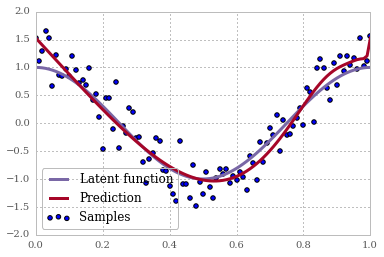

In [14]:
plot_model(PolynomialRidgeRegression(100, 0.01).fit(X, y))

**Problems:**

* regularization coefficient has to be selected
* does not address the cubic complexity

## Kernel Regression

We can express $\boldsymbol{w}$ as a weighted sum of the training data
$$\boldsymbol{w} = \boldsymbol{X}^T \boldsymbol{\alpha}$$

Which leads to the **dual problem**
$$\arg \min_\boldsymbol{\alpha} \frac{1}{2} || \boldsymbol{y} - \boldsymbol{X} \boldsymbol{X}^T \boldsymbol{\alpha}||^2_2$$

We call $\boldsymbol{K} = \boldsymbol{X}\boldsymbol{X}^T \in \mathbb{R}^{N \times N}$ the Gram matrix so that we can find the minimum at
\begin{eqnarray*}
&& 0 = \boldsymbol{K}\boldsymbol{K} \boldsymbol{\alpha} - \boldsymbol{K} \boldsymbol{y}\\
&\Leftrightarrow& \boldsymbol{K}\boldsymbol{K} \boldsymbol{\alpha} = \boldsymbol{K} \boldsymbol{y}\\
&\Leftrightarrow& \boldsymbol{\alpha}
= \boldsymbol{K}^{-1} \boldsymbol{y}
\end{eqnarray*}

### Kernel Trick

Instead of the *linear kernel* $k(\boldsymbol{x}, \boldsymbol{x}') = \boldsymbol{x}^T \boldsymbol{x}'$, we can use any Mercer kernel to build the Gram matrix $\boldsymbol{K}$. The intuition behind this is that we use another **definition of similarity** when we use another kernel.

* Linear kernel: $k(\boldsymbol{x}, \boldsymbol{x}') = \boldsymbol{x}^T \boldsymbol{x}'$
* Radial basis function (RBF) kernel:
  $k(\boldsymbol{x}, \boldsymbol{x}') = \exp \left( - \gamma ||\boldsymbol{x} - \boldsymbol{x}'||^2 \right)$
* [Polynomial kernel](http://en.wikipedia.org/wiki/Polynomial_kernel)
* [String kernels](http://en.wikipedia.org/wiki/String_kernel)
* [Graph kernels](http://en.wikipedia.org/wiki/Graph_kernel)
* ...

In [15]:
from sklearn.metrics.pairwise import pairwise_kernels


class KernelRegression(BaseEstimator, RegressorMixin):
    def __init__(self, kernel, **kernel_args):
        self.kernel = kernel
        self.kernel_args = kernel_args

    def fit(self, X, y):
        self.X = X
        K = pairwise_kernels(self.X, metric=self.kernel, **self.kernel_args)
        self.alpha = np.linalg.pinv(K).dot(y)
        return self

    def predict(self, X):
        K_star = pairwise_kernels(X, self.X, metric=self.kernel, **self.kernel_args)
        return K_star.dot(self.alpha)

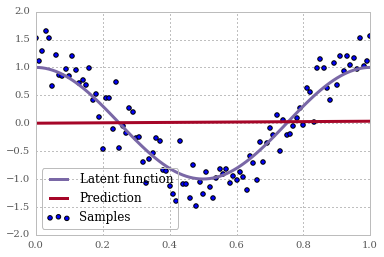

In [16]:
plot_model(KernelRegression("linear").fit(X, y))

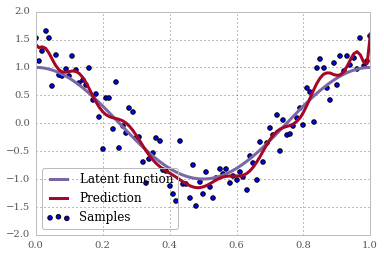

In [17]:
plot_model(KernelRegression("rbf", gamma=10.0).fit(X, y))

**Problems:**

* overfitting
* kernel has to be selected (often less critical than features)
* complexity with respect to number of samples is $O(N^3)$

## Kernel Ridge Regression

We start from **ridge regression**

$$\arg \min_\boldsymbol{w} \frac{1}{2} || \boldsymbol{y} - \boldsymbol{X} \boldsymbol{w} ||^2_2 + \frac{\gamma}{2} \boldsymbol{w}^T \boldsymbol{w}.$$

and replace again $\boldsymbol{w} = \boldsymbol{X}^T \boldsymbol{\alpha},$ so that

$$\boldsymbol{w}^T \boldsymbol{w} = \left( \boldsymbol{X}^T \boldsymbol{\alpha} \right)^T \left( \boldsymbol{X}^T \boldsymbol{\alpha} \right) = \boldsymbol{\alpha}^T \boldsymbol{X} \boldsymbol{X}^T \boldsymbol{\alpha} = \boldsymbol{\alpha}^T \boldsymbol{K} \boldsymbol{\alpha},$$

which results in a modification of the dual problem

$$\arg \min_\boldsymbol{w} \frac{1}{2} || \boldsymbol{y} - \boldsymbol{K} \boldsymbol{\alpha} ||^2_2 + \frac{\gamma}{2} \boldsymbol{\alpha}^T \boldsymbol{K} \boldsymbol{\alpha}.$$

The solution is
\begin{eqnarray*}
0 &=& \boldsymbol{K} \left( \boldsymbol{K} \boldsymbol{\alpha} - \boldsymbol{y} \right) + \gamma \boldsymbol{K} \boldsymbol{\alpha}\\
&=& \boldsymbol{K} \boldsymbol{K} \boldsymbol{\alpha} - \boldsymbol{K} \boldsymbol{y} + \gamma \boldsymbol{K} \boldsymbol{\alpha}\\
\Leftrightarrow && \left(\boldsymbol{K} + \gamma \boldsymbol{I} \right)^{-1} \boldsymbol{y} = \boldsymbol{\alpha}
\end{eqnarray*}

In [18]:
class KernelRidgeRegression(BaseEstimator, RegressorMixin):
    def __init__(self, kernel, lmbda, **kernel_args):
        self.kernel = kernel
        self.lmbda = lmbda
        self.kernel_args = kernel_args

    def fit(self, X, y):
        self.X = X
        K = pairwise_kernels(self.X, metric=self.kernel, **self.kernel_args)
        self.alpha = np.linalg.pinv(K + self.lmbda * np.eye(X.shape[0])).dot(y)
        return self

    def predict(self, X):
        K_star = pairwise_kernels(X, self.X, metric=self.kernel, **self.kernel_args)
        return K_star.dot(self.alpha)

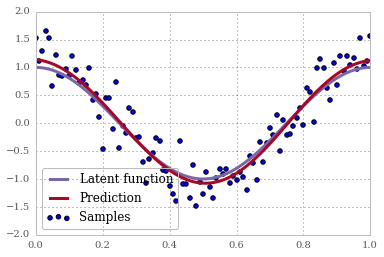

In [19]:
plot_model(KernelRidgeRegression("rbf", lmbda=1.0, gamma=10.0).fit(X, y))

## Gaussian Process Regression

Kernels that are used for GPR (covariance functions) usually have **more hyperparameters** than kernels that we have been looking at before. However, the hyperparameter optimization of GPR is much better than other methods (but more computationally complex).

* RBF kernel:
$$k(\boldsymbol{x}^{(1)}, \boldsymbol{x}^{(2)}) = \exp \left( - \gamma \lvert\lvert\boldsymbol{x}^{(1)} - \boldsymbol{x}^{(2)}\rvert\rvert^2 \right)$$
* Squared exponential kernel:
$$k(\boldsymbol{x}^{(1)}, \boldsymbol{x}^{(2)}) = \exp \left( - \sum_i l_i \lvert\lvert\boldsymbol{x}^{(1)}_i - \boldsymbol{x}^{(2)}_i\rvert\rvert^2 \right)$$

We maximize the marginal likelihood $p(\boldsymbol{y}|\boldsymbol{X})$.

We minimize the log-likelihood
$$\log p(\boldsymbol{y}|\boldsymbol{X}) = - \frac{1}{2} \boldsymbol{y} \boldsymbol{K}^{-1} \boldsymbol{y} - \frac{1}{2} \log |\boldsymbol{K}| - \frac{N}{2} \log (2 \pi)$$
with respect to the kernel's hyperparameters $\boldsymbol{\theta}$.

The derivative can be computed as
$$\frac{\partial}{\partial \theta_j} \log p(\boldsymbol{y}|\boldsymbol{X}) = \frac{1}{2} tr \left( (\boldsymbol{\alpha} \boldsymbol{\alpha}^T - \boldsymbol{K}^{-1}) \frac{\partial \boldsymbol{K}}{\partial \theta_j} \right)$$

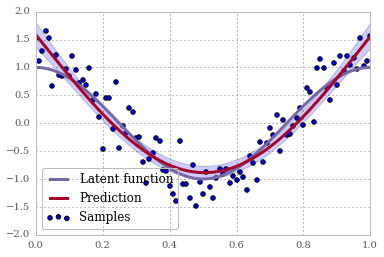

In [20]:
from sklearn.gaussian_process import GaussianProcess


gpr = GaussianProcess(nugget=0.1).fit(X, y)
plot_model(gpr)
y_pred, y_mse = gpr.predict(X, eval_MSE=True)
plt.fill_between(x, y_pred - 2 * np.sqrt(y_mse), y_pred + 2 * np.sqrt(y_mse), alpha=0.2)

**Problems:**

* does not address the cubic complexity

## Support Vector Regression

Support vector algorithms usually have constrained optimization problem. In this case, we want to optimize

$\arg \min_{\boldsymbol{w}} \frac{1}{2} ||\boldsymbol{w}||^2$ subject to $\begin{cases}
\xi_i \leq \epsilon\\
\xi_i^* \leq \epsilon\\
\end{cases}$, where $\begin{array}{l}\xi_i = y_i - \boldsymbol{w}_i^T \boldsymbol{x}_i - b\\\xi_i^* = \boldsymbol{w}_i^T \boldsymbol{x}_i + b - y_i\end{array}$.

In comparison to kernel ridge regression, this will result in only a few **support vectors** that will be used for predictions instead of the whole training set.

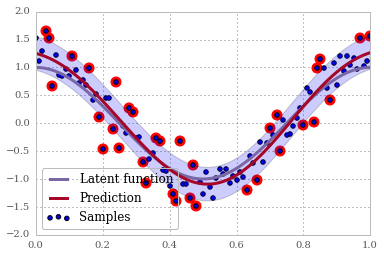

In [21]:
from sklearn.svm import SVR


def plot_svr(svr):
    plt.scatter(x[svr.support_], y[svr.support_], color="r", s=100)
    plot_model(svr)
    plt.fill_between(x, svr.predict(X) - svr.epsilon,
                     svr.predict(X) + svr.epsilon, alpha=0.2)

epsilon = 0.3
svr = SVR("rbf", epsilon=epsilon, gamma=10.0).fit(X, y)
plot_svr(svr)

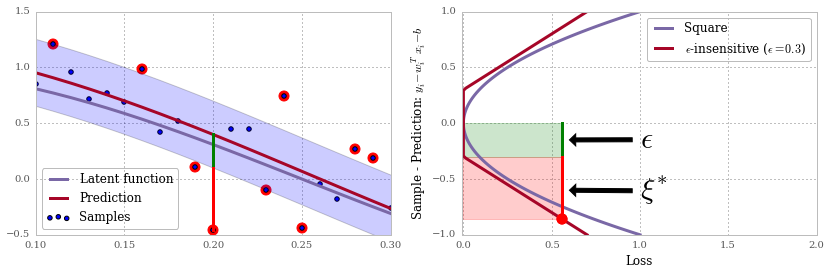

In [22]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plot_svr(svr)
svi = svr.support_[6]
svy = svr.predict([X[svi]])[0]
errori = y[svi] - svy
plt.plot([x[svi], x[svi]], [svy, svy + epsilon * np.sign(errori)], c="g")
plt.plot([x[svi], x[svi]], [svy + epsilon * np.sign(errori), y[svi]], c="r")
plt.setp(plt.gca(), xlim=(0.1, 0.3), ylim=(-0.5, 1.5))

square_loss = lambda d: d ** 2
epsilon_insensitive = lambda d, epsilon: np.maximum(0.0, np.abs(d) - epsilon)

plt.subplot(122)
d = np.linspace(-1, 1, 100)
plt.plot(square_loss(d), d, label="Square")
plt.plot(epsilon_insensitive(d, epsilon=0.3), d,
         label="$\epsilon$-insensitive ($\epsilon=0.3$)")
loss = epsilon_insensitive(errori, epsilon=0.3)
plt.scatter(loss, errori, color="r", s=100, zorder=10)
plt.scatter(loss, errori, color="r", s=100, zorder=10)
plt.plot([loss, loss], [0, epsilon * np.sign(errori)], c="g")
plt.fill_between([0, loss], [0, 0], [epsilon * np.sign(errori),
                                     epsilon * np.sign(errori)],
                 color="g", alpha=0.2)
plt.plot([loss, loss], [errori, epsilon * np.sign(errori)], c="r")
plt.fill_between([0, loss], [errori, errori], [epsilon * np.sign(errori),
                                               epsilon * np.sign(errori)],
                 color="r", alpha=0.2)
plt.gca().annotate("$\epsilon$", xy=(loss, -0.15), xytext=(1, -0.22),
                   fontsize=30, arrowprops=dict(facecolor="black", shrink=0.1))
plt.gca().annotate("$\\xi^*$", xy=(loss, -0.6), xytext=(1, -0.68),
                   fontsize=30, arrowprops=dict(facecolor="black", shrink=0.1))
plt.setp(plt.gca(), xlim=(-0.01, 2), ylim=(-1, 1),
         xlabel="Loss", ylabel="Sample - Prediction: $y_i - w_i^T x_i - b$")
plt.legend(loc="upper right")

**Problems:**

* epsilon and kernel have to be selected

## Neural Nets

![ANN](http://upload.wikimedia.org/wikipedia/en/1/1d/Neural_network_example.png)
Source: http://en.wikipedia.org/wiki/File:Neural_network_example.png

* A neural net is an interconnected assembly of neurons.
* Each neuron behaves like a linear model with a nonlinear activation function.
* Learning is complicated and involves optimizing a non-convex objective (incremental minimization of error function by changing the weights).

Objective function:
$$\arg \min_\boldsymbol{w} \frac{1}{2} || \boldsymbol{y} - \hat{\boldsymbol{y}} ||^2_2.$$

Because $\hat{\boldsymbol{y}}$ is a nonlinear term, we have to use a gradient-based optimizer to change the weights of the neural net.

Each neuron computes
$$g(\boldsymbol{X}\boldsymbol{w}).$$

(Weighted sum of inputs + nonlinear activation function, e.g. $\tanh$.)

In [23]:
from openann import Net, Activation, DataSet, LMA


class NeuralNet(BaseEstimator, RegressorMixin):
    def __init__(self, n_nodes, gamma=0.0):
        self.n_nodes = n_nodes
        self.gamma = gamma

    def fit(self, X, y):
        n_features = X.shape[1]
        self.net = Net()
        self.net.set_regularization(0.0, self.gamma, 0.0)
        self.net.input_layer(n_features)
        self.net.fully_connected_layer(self.n_nodes, Activation.LOGISTIC)
        self.net.output_layer(1, Activation.LINEAR)
        Y = y.reshape(len(X), 1)
        dataset = DataSet(X, Y)
        lma = LMA({"maximal_iterations": 300})
        lma.optimize(self.net, dataset)
        return self

    def predict(self, X):
        return self.net.predict(X).ravel()

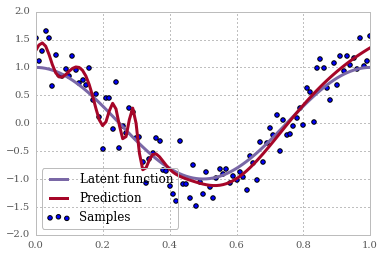

In [24]:
plot_model(NeuralNet(100).fit(X, y))

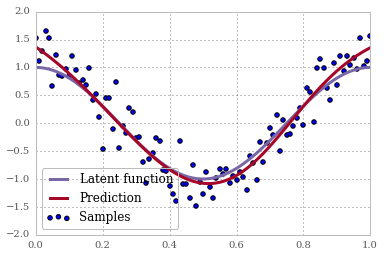

In [25]:
plot_model(NeuralNet(100, gamma=1e-4).fit(X, y))

**Problems:**

* topology, regularization coefficients, optimization algorithm have to be selected
* non-convex optimization
* might require a lot of training time although prediction is fast

## Comparison

In [26]:
def generate_data_1(n_samples, sigma, random_state=None):
    random_state = check_random_state(random_state)
    x = np.linspace(0, 1, n_samples)
    X = x[:, np.newaxis]
    y_true = np.cos(4 * np.pi * x) + 2 * x
    y = y_true + sigma * random_state.randn(n_samples)
    return x, X, y_true, y

def generate_data_2(n_samples, sigma, random_state=None):
    random_state = check_random_state(random_state)
    x = np.linspace(0, 1, n_samples)
    X = x[:, np.newaxis]
    y_true = (4 * x - 1.0) ** 2
    y = y_true + sigma * random_state.randn(n_samples)
    return x, X, y_true, y

def generate_data_3(n_samples, sigma, random_state=None):
    random_state = check_random_state(random_state)
    x = np.linspace(0, 1, n_samples)
    X = x[:, np.newaxis]
    y_true = 5.0 * x
    y_true[x < 0.5] -= 3.0
    y = y_true + sigma * random_state.randn(n_samples)
    return x, X, y_true, y

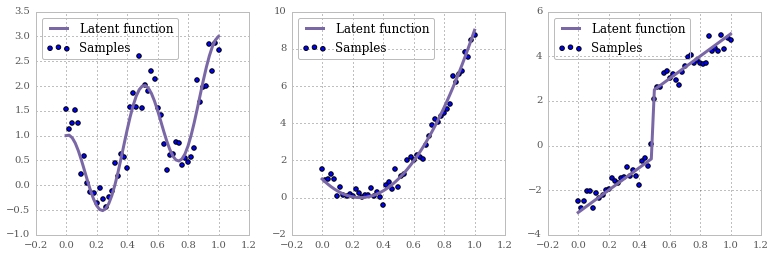

In [27]:
plt.figure(figsize=(13, 4))
for i, gen_data in enumerate([generate_data_1, generate_data_2, generate_data_3]):
    plt.subplot(1, 3, 1 + i)
    x, X, y_true, y = gen_data(51, 0.3, 0)
    plt.plot(x, y_true, label="Latent function")
    plt.scatter(x, y, label="Samples")
    plt.legend(loc="upper left")

In [28]:
def plot_model_on_datasets(model):
    plt.figure(figsize=(13, 4))
    for j, gen_data in enumerate([generate_data_1, generate_data_2, generate_data_3]):
        plt.subplot(1, 3, 1 + j)
        x, X, y_true, y = gen_data(51, 0.3, 0)
        plt.plot(x, y_true, label="Latent function")
        plt.scatter(x, y, label="Samples")
        model.fit(X, y)
        plt.plot(x, model.predict(X), label="Prediction")
        plt.legend(loc="upper left")

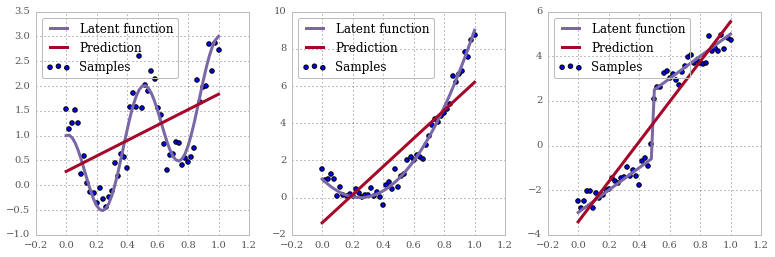

In [29]:
plot_model_on_datasets(LinearRegression())

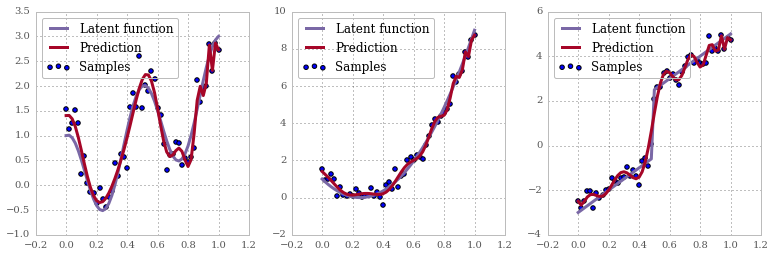

In [30]:
plot_model_on_datasets(PolynomialRegression(100))

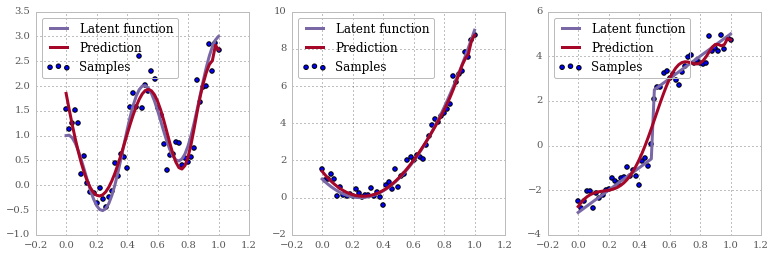

In [31]:
plot_model_on_datasets(PolynomialRidgeRegression(100, gamma=1e-5))

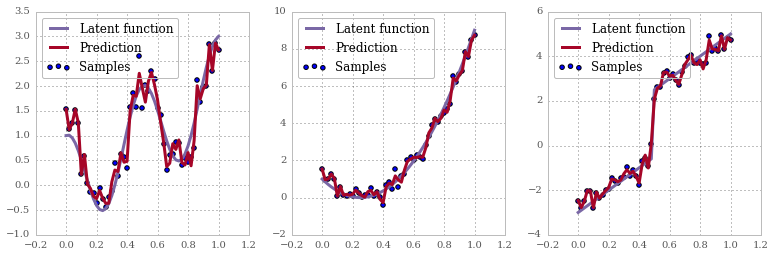

In [32]:
plot_model_on_datasets(KernelRegression("rbf", gamma=100.0))

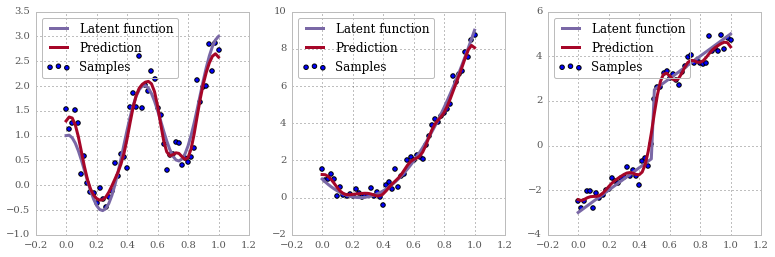

In [33]:
plot_model_on_datasets(KernelRidgeRegression("rbf", lmbda=0.1, gamma=100.0))

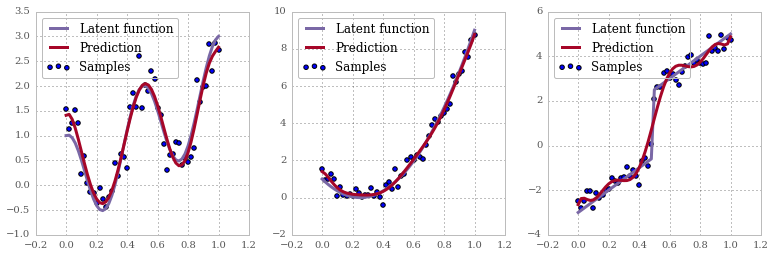

In [34]:
plot_model_on_datasets(GaussianProcess(nugget=1e-12))

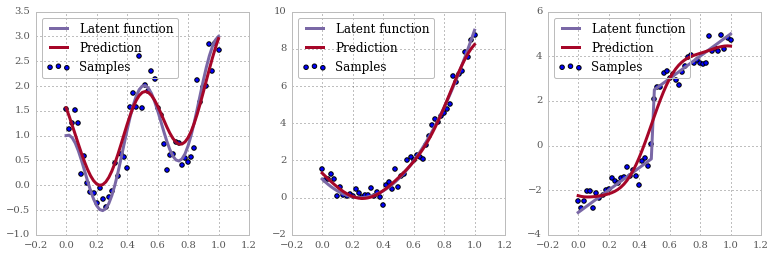

In [35]:
plot_model_on_datasets(SVR("rbf", epsilon=0.5, gamma=10.0, C=10.0))

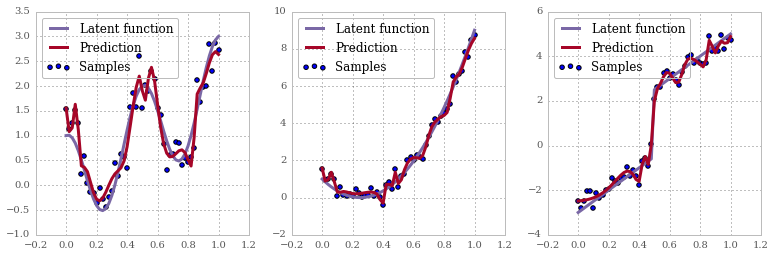

In [36]:
plot_model_on_datasets(NeuralNet(50))

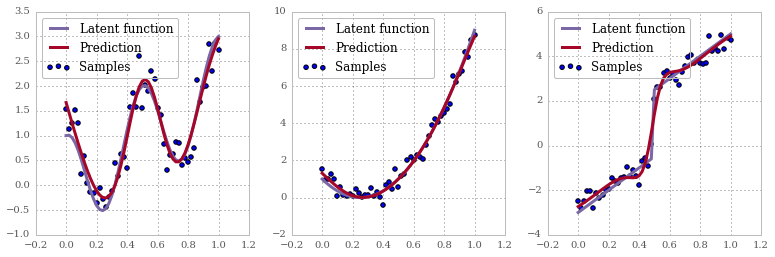

In [37]:
plot_model_on_datasets(NeuralNet(50, gamma=1e-4))

## Model Selection

**How can I evaluate my result?**

Appropriate metrics for regression are e.g.
* Mean squared error (MSE): $\frac{1}{N} \sum_n \left( \hat{y}_n - y_n \right)^2$
* Mean absolute error (MAE): $\frac{1}{N} \sum_n \lvert \hat{y}_n - y_n \rvert$
* [Coefficient of determination](http://en.wikipedia.org/wiki/Coefficient_of_determination) ($R^2$)

**What is the best model for me?**

That depends on...
* the number of samples
* the number of features
* the complexity of the latent function
* what kind of noise do we expect?
* are we learning online?
* ...

**How do we select appropriate parameters?**

* Grid search + cross-validation
* Bayesian optimization + validation set
* Bayesian hyperparameter estimation (e.g. Gaussian process regression)

**Do I have enough samples? Is my model complex enough?**

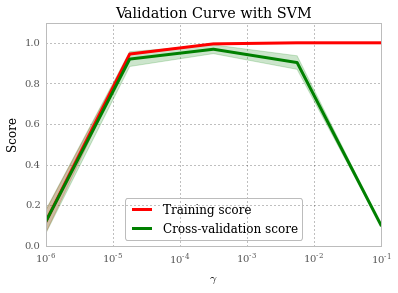

In [38]:
# Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve

digits = load_digits()
X, y = digits.data, digits.target

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), X, y, param_name="gamma", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=4)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")

In [39]:
# Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.learning_curve import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

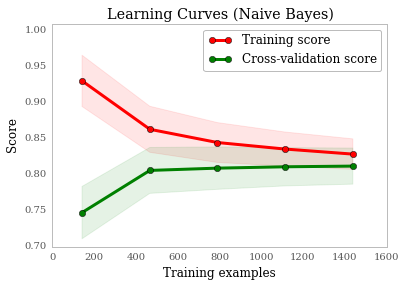

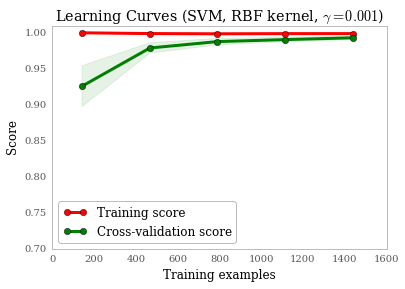

In [40]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation


digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(digits.data.shape[0], n_iter=100,
                                   test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = cross_validation.ShuffleSplit(digits.data.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

## More Topics

* [Generalized linear models](http://en.wikipedia.org/wiki/Generalized_linear_model)
* [Bayesian regression](http://en.wikipedia.org/wiki/Bayesian_linear_regression)
* [SVR tutorial](http://alex.smola.org/papers/2003/SmoSch03b.pdf)
* [Regression with decision trees](http://scikit-learn.org/stable/modules/tree.html#tree-regression)
* [Ensemble learning](http://en.wikipedia.org/wiki/Ensemble_learning)
* [Online/incremental/out-of-core learning](http://scikit-learn.org/stable/modules/scaling_strategies.html)
* ...